<a href="https://colab.research.google.com/github/jessicaychen/OCT-Image-Segmentation-ML/blob/master/UNET_OCT_Blood_Vessel_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**


In [4]:
import tensorflow as tf
import keras
import os
import PIL
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

from IPython.display import clear_output
from tqdm import tqdm_notebook, tnrange

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



**Import dataset**

*note - resizing binary images down will create a grayscale image


In [5]:
 #! ls /content/drive/My\ Drive/ML\ Data
from google.colab import drive
drive.mount('/content/drive')

im_height, im_width, border = 256, 256, 5

ids = next(os.walk("drive/My Drive/ML Data/Input"))[2] # list of names all images in the given path
print("# of images =", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32) # images
Y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32) # masks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
# of images = 99


In [6]:
# tqdm is used to display the progress bar
DIR = "drive/My Drive/ML Data/"

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(DIR+"Input/"+id_, color_mode="grayscale")
    x_img = img_to_array(img)
    # x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(DIR+"Mask/"+id_, color_mode="grayscale"))
    # mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    Ytemp = mask/255.0
    Y[n] = np.where(Ytemp > 0.5, 1, 0) # minor grayscale -> binary

# img = cv2.imread('/content/drive/My Drive/ML Data/Input/cSLO02.png')
# print(img.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
# Check size and content for the images/masks
imgTemp = X[1]
print(imgTemp.shape)

print(Y[1])

In [8]:
# Split train and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Mask')

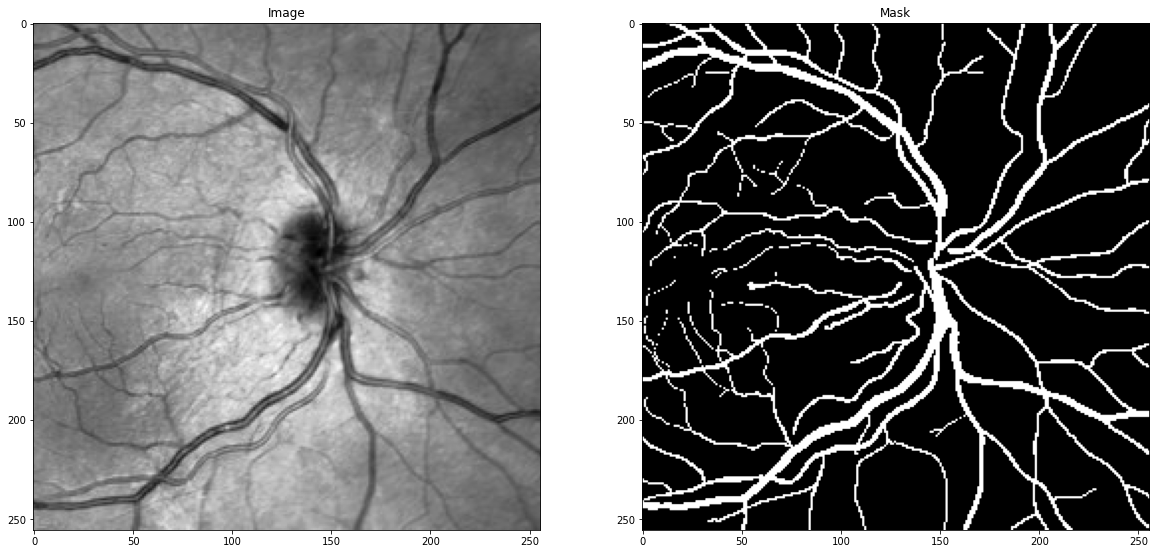

In [9]:
# Plot to show
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))

ax1.imshow(X_train[1].squeeze(), cmap='Greys_r')
ax1.set_title('Image')
ax2.imshow(Y_train[1].squeeze(), cmap='Greys_r')
ax2.set_title('Mask')


In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [12]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-OCT-BV.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
results = model.fit(X_train, Y_train, batch_size=3, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, Y_valid))

Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.9057
Epoch 00001: val_loss improved from inf to 0.42480, saving model to model-OCT-BV.h5
30/30 [==============================] - 2s 60ms/step - loss: 0.3585 - accuracy: 0.9057 - val_loss: 0.4248 - val_accuracy: 0.9111
Epoch 2/100
28/30 [===========================>..] - ETA: 0s - loss: 0.2553 - accuracy: 0.9271
Epoch 00002: val_loss improved from 0.42480 to 0.30028, saving model to model-OCT-BV.h5
30/30 [==============================] - 1s 28ms/step - loss: 0.2539 - accuracy: 0.9277 - val_loss: 0.3003 - val_accuracy: 0.9112
Epoch 3/100
29/30 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9338
Epoch 00003: val_loss improved from 0.30028 to 0.27814, saving model to model-OCT-BV.h5
30/30 [==============================] - 1s 29ms/step - loss: 0.2181 - accuracy: 0.9336 - val_loss: 0.2781 - val_accuracy: 0.9112
Epoch 4/100
29/30 [============================>.] - ETA: 0s - lo

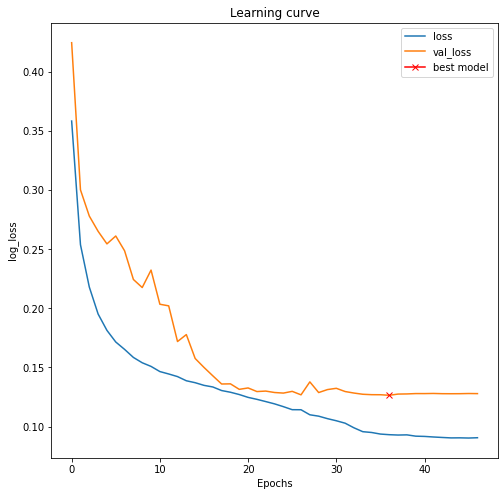

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [18]:
# load the best model
model.load_weights('model-OCT-BV.h5')

In [19]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, Y_valid, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9528


[0.12646915018558502, 0.9528487920761108]

In [20]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 16ms/step


In [21]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [39]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='Greys_r')
    # if has_mask:
    #     ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    # ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze(), cmap="Greys_r")
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), cmap="Greys_r", vmin=0, vmax=1)
    # if has_mask:
    #     ax[2].contour(y[ix].squeeze(), cmap="Greys_r", colors='k', levels=[0.5])
    ax[2].set_title('BV Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), cmap="Greys_r", vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k',levels=[0.5])
    ax[3].set_title('BV Predicted Binary');

**Predictions on Training Data**

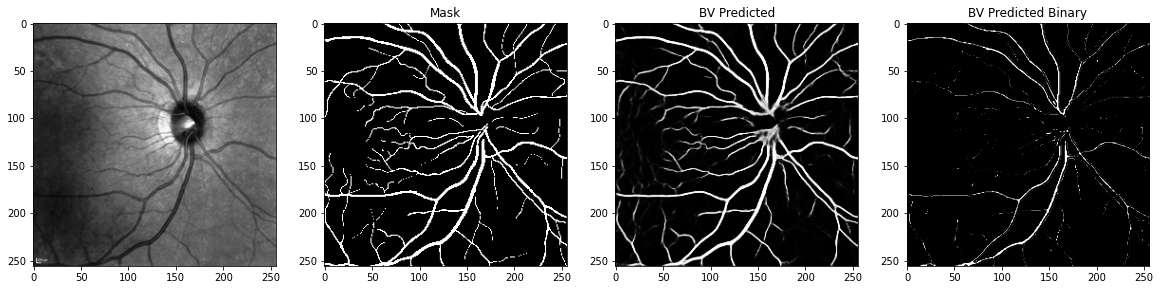

In [40]:
plot_sample(X_train, Y_train, preds_train, preds_train_t)

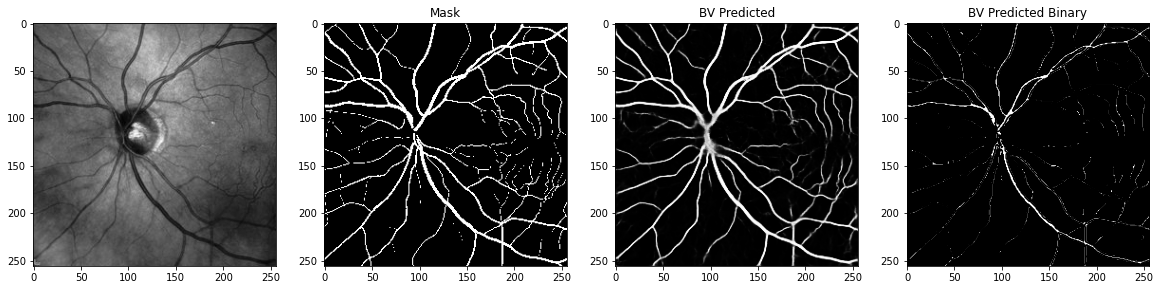

In [41]:
plot_sample(X_train, Y_train, preds_train, preds_train_t)

**Predictions on Validation Data**

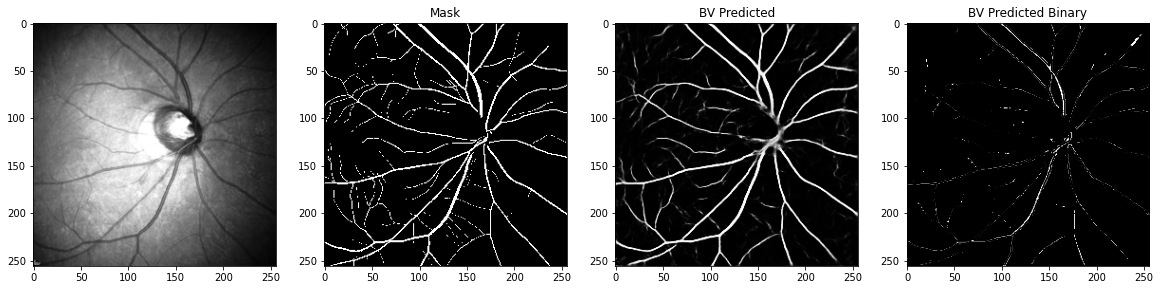

In [42]:
plot_sample(X_valid, Y_valid, preds_val, preds_val_t)

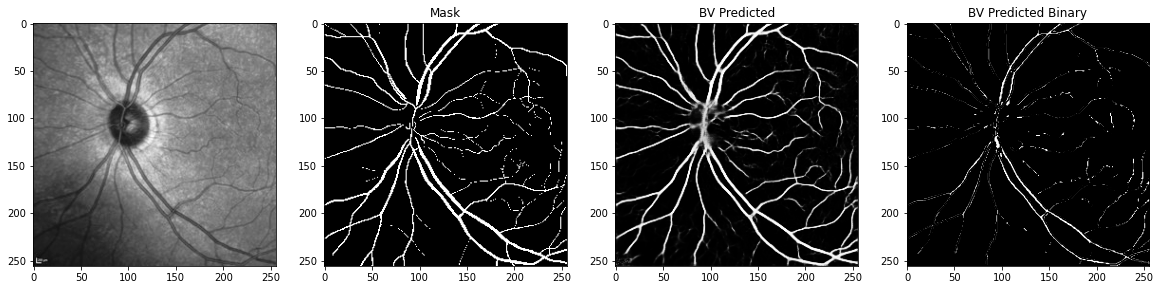

In [43]:
plot_sample(X_valid, Y_valid, preds_val, preds_val_t)